# SCI-SEQ Meiotic Drive Project Notes


### Scripts/Modules

In [2]:
#### Import all modules necessary for the scripts in jupyter notebooks
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
chromosomes = ('2L', '2R', '3L', '3R', 'X')

In [3]:
def load_reference(reference, path):
    np_file = os.path.join(path, reference)
    reference = np.load(np_file)
    return reference


def snp_density(ref='DGRP-882_DGRP-129'):
    #Doing some rudimentary analysis on number of informative SNPs per chromosome in a particular comparison
    chromosomes = ('2L', '2R', '3L', '3R', 'X')
    reference_snps = load_reference(path='/home/iskander/Documents/MEIOTIC_DRIVE/', reference='882_129.snp_reference.npy')
    print(ref)
    for scaffolds in range(len(chromosomes)):#Generate some rough summary statistics
        num_snps = len(reference_snps[scaffolds][:,0])
        scaffold_snps = reference_snps[scaffolds]
        snp_holder = [0 for x in range(num_snps)]
        dist_snps = []
        for snp in range(1, len(scaffold_snps)):#average distance between SNPs
            diff = scaffold_snps[snp][0] - scaffold_snps[snp-1][0]
            dist_snps.append(diff)
        avg_dist = np.average(dist_snps)
        var_dist = np.var(dist_snps)
        
        
        print('{0}: SNP every {1:.2f} bp; {3:.2f} bp standard deviation in density ({2} total SNPs)'.format(chromosomes[scaffolds], avg_dist, num_snps, var_dist**(1/2)))
        
#Let's window across the chromosome arm and calculate the SNP density in say 5kb bins to plot the density better
        binsize= 5000
        snp_list = []
        bin_list = []
        snp_positions = scaffold_snps[:,0]
        for bins in range(scaffold_snps[0][0], scaffold_snps[-1][0]-4999, 5000): 
            bin_list.append((bins+2500)/ 1000000)
            snp_count = 0 
            for position in range(len(snp_positions)):
                if snp_positions[position] >= bins and snp_positions[position] <= bins+binsize:
                    snp_count += 1
                elif snp_positions[position] > bins+binsize:
                    snp_positions = snp_positions[position:]
                    break
            snp_list.append(snp_count*(.02))#Get SNPs per 100bps
        avg = np.average(snp_list)
        legends = ['5kb Bins', 'Chromosome Wide Average\n({0:.2f} SNPs/100bp)'.format(avg)]
        plt.figure(figsize=(20,2.5))
        plt.title('{0} Informative SNP Density'.format(chromosomes[scaffolds]))
        plt.ylabel('SNPs / 100bp')
        plt.xlabel('Position (Mb)')
        sns.lineplot(bin_list, snp_list)
        plt.axhline(avg, linestyle='--', color='red')
        plt.figlegend(legends)
        plt.show()
                
                    

In [4]:
def analyzeSIM(npy, ref_snp, path):
    
    refPath = os.path.join(path, ref_snp)
    simSNP = npy
    refSNP = np.load(refPath)
  
    parental_SNPs = []
    for chrom in range(5):
        p_snps = []
        for snp in range(len(refSNP[chrom])):
            if simSNP[chrom][snp][1] == refSNP[chrom][snp][1]: #If it is P1
                
                p_snps.append([simSNP[chrom][snp][0], 1])
            elif simSNP[chrom][snp][1] == refSNP[chrom][snp][2]: #if it is P2
        
                p_snps.append([simSNP[chrom][snp][0], 2])
                
            else: #If it is a sequencing error or de novo mutation
                p_snps.append([simSNP[chrom][snp][0], 0])
                
        parental_SNPs.append(np.asarray(p_snps))
    parental_SNPs = np.asarray(parental_SNPs)
    
    
    return(parental_SNPs)



def plot_snps(snps, simID):####### THIS FUNCTION IS GARBAGE
    P1 = []
    P2 = []
    for i in range(5):
        for snp in snps[i]:
            if snp[1] == 1:
                P1.append(snp)

            elif snp[1] == 2:
                P2.append(snp)
            else:
                pass
        p1_1, p1_2 = zip(*P1)
        p2_1, p2_2 = zip(*P2)
        #fig = plt.figure(figsize=(5,2.5))
        plt.title('{0}_{1}'.format(chromosomes[i],simID ))
        sns.lineplot(p1_1, p1_2)
        sns.lineplot(p2_1, p2_2 )
        plt.show()
        
        
def bin_SNP(scaffold_snps, chromosome='holder'): ###THIS FUNCTION MAY BE GARBAGE

        binsize= 5000
        p1_list = []
        p2_list = []
        p_proportions = []
        bin_list = []
        snp_positions = scaffold_snps[:,0]
        for bins in range(scaffold_snps[0][0], scaffold_snps[-1][0]-(binsize-1), binsize): 
            bin_list.append((bins+binsize/2)/ 1000000)
            P1 = 0 
            P2 = 0
            
            for position in range(len(snp_positions)):
                
                if snp_positions[position] >= bins and snp_positions[position] <= bins+binsize:
                    if scaffold_snps[position][1] == 1:
                        P1 += 1
                    elif scaffold_snps[position][1] == 2:
                        P2 += 1
                    else:
                        pass
                elif snp_positions[position] > bins+binsize:
                    snp_positions = snp_positions[position:]
                    
                    break
           
            p1_list.append(P1)#Get P1/P2 freq. 
            p2_list.append(P2)
            p_proportions.append(P1/max(1,P2))
        legends = ['5kb Bins']
        fig = plt.figure(figsize=(20,5))
        axs = fig.subplots(2,sharex=True)
        fig.suptitle('{0} P1/P2 Alleles'.format(chromosome))
        plt.ylabel('Parental Alleles')
        plt.xlabel('Position (Mb)')
        sns.lineplot(bin_list, p_proportions, ax=axs[0])
        sns.lineplot(bin_list, p1_list, ax = axs[1])
        sns.lineplot(bin_list, p2_list, ax=axs[1])
        

        plt.figlegend(legends)
        plt.tight_layout(rect=[0,0,.9,1])
        plt.show()

# Motivation:
http://www.genetics.org/content/206/1/451

We will take advantage of single cell genomics to determine the presence of meiotic drive in an F2 fly backcross. The benefit of using this is that we will be able to sample individual haplotypes. This allows us to determine if multiple cells are being contributed to the sequencing run by the same individual. This is important because it is possible that there are genotypic size differences in the flies that would make an unequal contribution of cells per genotype that are not dependent on a meiotic drive signal. In order to get around this issue we are using SCI-SEQ to sequence thousands of cells at low coverage, and use some clustering to collapse cells from the same individual together.


# Genomics Strategy
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5908213/?fbclid=IwAR28Oy13lqD1i3FJWg0ScFiNL_5YcZxbFw48qycoz0Xd6lj6Lg1HKvFF1QQ

To perform a high throughput genomics sequencing of single cells of a large heterogenous population I am using a SCI-SEQ protocol. The ATAC-SEQ version has been optimized extensively by the Solloway lab and particularly Roman Spektor. There are some slight differences between these protocols. The main is that the nucleosomes must be depleted in the nuclei before the Tn5/Library prep. I don't think that it should be particularly difficult to optimize this, but it will take some optimization. Generally, the idea is to have a heterogenous solution of nuclei and sequence single nuclei at low coverage. For each meiotic drive cross we should put in several thousand flies (~10,000 flies). The point of using so many individuals is that this way the probability of sampling a cell from the same individual becomes very very small, thus we can obtain several thousand unique haplotypes. Maximizing the unique haplotypes is important, but also since the coverage of the individuals is going to be so low it may be beneficial to actually have some duplicate sequenced individuals as we can collapse those reads and get a better depth on each SNP. Depending on how the pilot study goes the number of individuals, and the number of reads per individual necessary can be tweaked and optimized. I have a suspicion that we may not need as many as 10,000, but I'm not entirely sure. 



# Statistical Analysis

https://pymc-devs.github.io/pymc/

The statistical analysis of the genomics data will be slightly complex and require some serious thought on modelling. The primary challenge that we must face is a way to call recombination breakpoints in single cells with very low coverage, and then find other individuals with identical breakpoints to call them as the same individual. This functions on a fundamental assumption that recombination breakpoints will be unique for each individual. I don't think is a completely unreasonable assumption, and it should be fairly straightforward to check these assumptions. If we find individuals who have overlapping recombination breakpoints, but a different combination of SNPs/genotypes then we would be able to find out if these assumptions are wrong. 

The general strategy is to create an interval where we predict a recombination breakpoint by a switching from P1 alleles to P2 alleles. We use the switching of alleles to construct some kind of distribution/interval based on some family of distributions. Then we cluster individuals with overlapping recombination breakpoint intervals, check the genotypes of the individuals and update our confidence on our breakpoint predictions. 

### Clustering Pseudocode:

    Convert BAM files of single cell genomes into a SNP array of positions an P1, or P2 alleles. 

    Take in the SNP data structure

    For each individual scan across the SNP array
        If there is a shift from P1/P2 alleles or vice versa call a recombination breakpoint 

    Use recombination breakpoint coordinates to cluster individuals
        Individuals with similar/same breakpoints will cluster
    For each cluster
        Check the genotypes
        If the genotypes are similar enough 
            Call clusters as same individuals
            Re-estimate the breakpoint distributions as more similar
        Else:
            Call cluster as distinct individuals
            Re-estimate the breakpoint distributions as more dis-similar
    
    Iterate through this process a determinate number of times; 
    or until some amount of certainty of breakpoint positions has been reached. 
    
    Collapse the final recombination breakpoint clusters and merge all of the SNPs/reads(?)
    These are our individuals for segregation distortion analysis.

### Distortion detection pseudocode

Do stuff



# Pilot proposal

To see if this method is viable for our detection segregation distortion I am proposing a small scale pilot study, and the generation of simulated data. 

## Simulations

It is important that before we spend money on sequencing that we have a proof of concept that our analysis will work in idealized conditions via simulations. So, I will simulate data that represent recombinant chromosomes from a cross of a segregation distorter at various strengths. My strategy is generally as follows:

1. Get reference genome of two DGRP lines.
2. Generate a VCF, or a SNP call to find all variant sites between the two.
3. Simulate reads/SNPs in proportion to a recombination frequency

### Get DGRP reference genomes:

The DGRP data should be found pretty easily from: http://dgrp2.gnets.ncsu.edu/. I'm going to use the DGRP lines: 

DGRP-882 x DGRP-129

I think I can just directly get VCF calls for each of the lines and don't need to create the VCF files myself.

#### VCF processing

I need to extract the columns of the two DGRP individuals that I care to simulate. I should be able to do this by using something simple like vcf-subset. Once I have those VCF columns I will determine which are the SNPs that are informative on each chromosome. I should convert the VCF into a numpy array or something that is easy to load/read in python for simplicities sake.

### Simulate reads/SNPs

#### Recombination map
In the simplest simulation scenario we will create SNP calls/reads off of freely recombining chromosomes without segregation distortion. 


#### Simulations
When I simulate reads off of the P1, or P2 alleles I must remember that each read is only going to sample off of one haplotype, and since I am only getting something like 1x-2x coverage at any given genome there is a possibility of by chance only sampling a P1 or P2 in a P1/P2 heterozygote.This is an important facet of the data I must make sure to recreate in my simulations.


## Crosses

For the pilot crosses I propose to generate ~2,000-10,000 flies (TBD), from four different crosses:

1. Putative meiotic driver (Wei et al. 2017)
2. Recessive lethal. (l/+ x l/+) ??
3. Isogenic cross (+/+ x +/+)
4. TBD (T23 stock, Russ???)

The putative meiotic driver is a pretty good no brainer. It's one of the more interesting finds from Kevin Wei's paper and it would be great to see if I can replicate his results using my methods. The recessive lethals and isogenic stock act as benchmarks for strong segregation distortion, and no segregation distortion. The recessive lethal will act as an extremely strong sign of segregation distortion as the signature will show a sharp decrease in frequency of the alleles surrounding the lethal allele; in other words the wt allele will show up as segregation distortion. The cross between two isogenic stocks will show no signature of segregation distortion and should act as our benchmark for a non-distorted cross. The fourth cross wil require a bit more thought -- I think a reasonable cross would be to use the Something Amazing T23, etc. from Corbett-Detig lab. It would be pretty sweet to get these guys sequenced finally and perform my analysis on the data and see if the phenotypic observations can be corroborated.



## Genomics

http://www.biotech.cornell.edu/brc/genomics/services/price-list#overlay-context=brc/genomics-facility/next-generation-sequencing
http://www.biotech.cornell.edu/node/555

I propose to divide one Tn5 plate in four evenly (24 wells for each cross). Each cross will be uniquely labelled and the information of which cells come from which cross will be able to be retrieved based on the unique Tn5 oligos on each 96 well plate. We will then perform one plate of PCR indexing downstream of the Tn5 indexing on 20-25 single nuclei per well. Which means that on average we should get ~600 nuclei per cross, and a total of ~2,400 nuclei in total.

As for sequencing either a HiSEQ2500, or NextSEQ500 lane with 75bp single end reads may be enough. This however, I need more expertise on and I think that Roman should be able to push me in the right direction here.



# Simulated data

### Reference SNP file generation

I used a VCF file from the DGRP and extracted the 882 and 129 individuals and then extracted all the informative SNPs for specified number of chromosomes. An informative SNP is a SNP where the alleles of P1 and P2 are distinct. Each informative SNP had its position and which allele was present for the P1 and P2 individual and was outputted to a numpy file with the following formatting:

        [2L [Position, P1_allele, P2_allele],
        2R [Positions, P1_allele, P2_allele], etc.]

        Each numpy array within the larger array will be for each chromosome arm: 2L, 2R, 3L, 3R, and X.
        Each allele will be encoded as:

        A:0
        T:1
        C:2
        G:3


### SNP density

Now that we have a reference numpy file generated for the informative SNPs I am interested in seeing the SNP density of these comparisons. This way I can do some rudimentary analysis of whether or not it would be possible to get decent recombination breakpoint information.

DGRP-882_DGRP-129
2L: SNP every 173.66 bp; 753.59 bp standard deviation in density (132330 total SNPs)


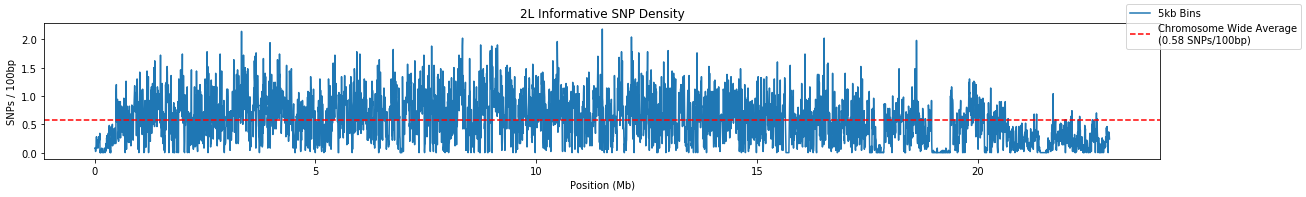

2R: SNP every 186.74 bp; 636.17 bp standard deviation in density (113182 total SNPs)


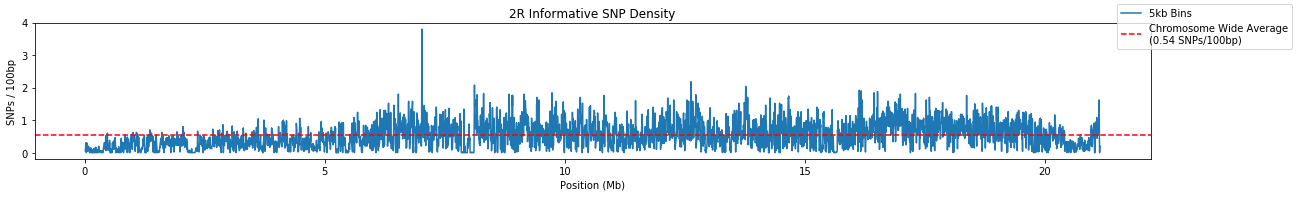

3L: SNP every 180.00 bp; 645.81 bp standard deviation in density (136050 total SNPs)


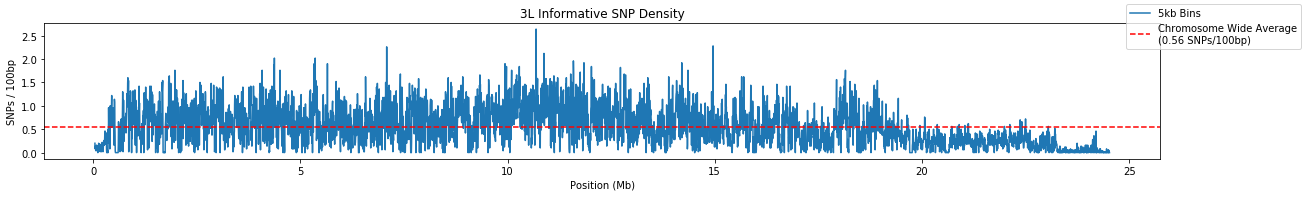

3R: SNP every 212.40 bp; 843.99 bp standard deviation in density (131340 total SNPs)


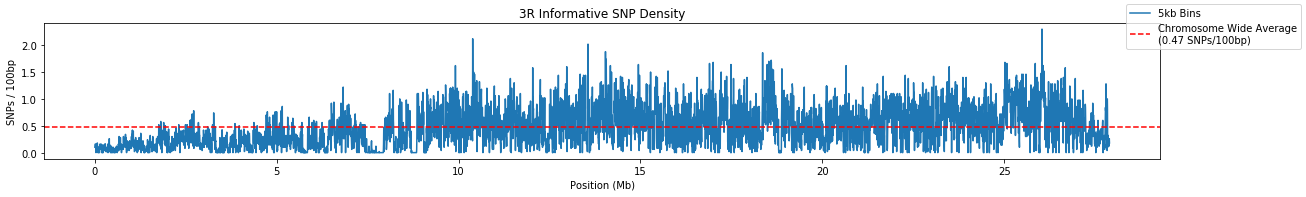

X: SNP every 285.17 bp; 1097.84 bp standard deviation in density (78485 total SNPs)


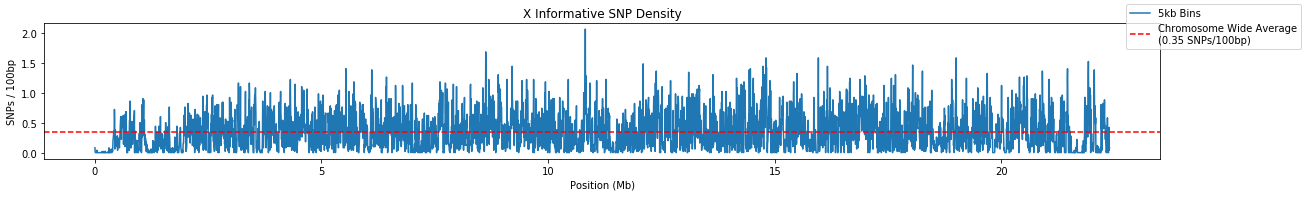

In [189]:
snp_density()

This actually seems like a pretty decent density of SNPs I am fairly optimistic that there is enough density of data that this will be a reasonable method to attempt. So, roughly we have a SNP every 200bp that is informative. This will mean that the confidence in our breakpoint estimates will be at best, like ~200bp intervals? If we have perfect information. In reality, it will most likely be much wider in the Kb region I am guessing. That is actually I think pretty acceptable, if the recombination breakpoint estimates end up being much larger -- 10, 20 Kb ,etc. then we will have a much harder time to do our clustering.

Something to consider doing is using this SNP density information to better estimate the recombination breakpoints, or rather to inform our 'confidence intervals'/distrbutions. We may be able to use this density information to parameterize the estimates of our recombination breakpoints e.g. a known area with low SNP density will be called less strongly than an area with high SNP density. But perhaps these things will end up being implicit in the analysis step anyways.

### Generate recombinant chromosomes:

Now that I have some confidence through pure visualization that there are enough informative SNPs that I could distinguish recombination breakpoints and allele frequencies of individuals I must start generating some simulated data off the reference SNPs. The plan is to generate recombinant chromosomes using a Drosophila recombination map to emulate true recombination as accurately as possible. 

I have written a script generate recombinant chromosomes off of the reference SNP data. An important assumption that I am making is that each SNP will be simulated independent of the other SNPs. This will be true for all SNPs that are further apart than the read size, but not for SNPs that fall within the same read. I chose to draw each SNP independently because the average distance of SNPs seems to be ~180-200 BP apart so would be drawn independently from a 75bp read almost always, and from  150bp reads probably most of the time. It also reduces the complexity of my program considerably, and if anything my analysis should have a slightly harder time with this data set than with the non-independent SNPs. 

#### Pseudocode

    Load reference numpy array

    For each chromosome:
        Choose initial parental state of gamete (P1, or P2)
        Determine a crossover event on the chromosome in the euchromatic regions
        
        Iterate through each SNP of each chromosome:
            If the SNP is on a portion that is homozygous for P1:
                Call a P1 allele with a probability of sequencing error
            If the SNP is on a portion that is heterozygous for P1/P2:
                Call a P1 or P2 allele with equal probability.
            


#### Analysis of test simulation

I will below perform some dirty visualization of the test simulation before I go further and develop more rigorous analysis. The point of this is to see how quickly I can call the SNPs as being from P1 or P2 and what patterns we can visualize of the heterozygous regions.

In [95]:
sim_path = os.path.join("/home/iskander/Documents/MEIOTIC_DRIVE/",'test_simulation.npy')

sim_np = np.load(sim_path)

called_snps = analyzeSIM(path="/home/iskander/Documents/MEIOTIC_DRIVE/", npy= sim_np, ref_snp="882_129.snp_reference.npy")


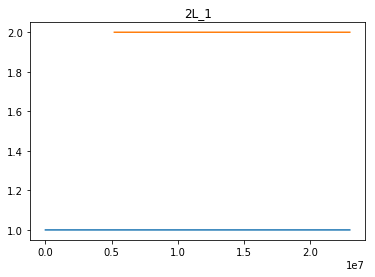

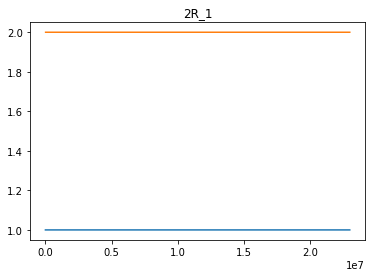

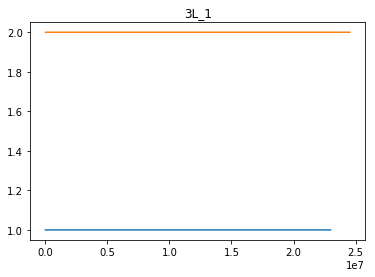

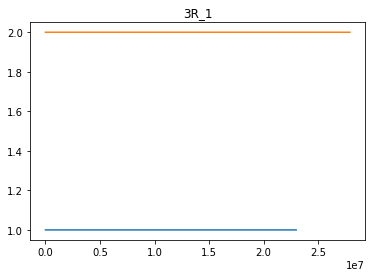

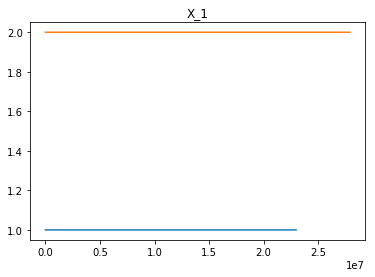

In [97]:
plot_snps(called_snps, simID =1)

Pure line graph shows us the exact point where we switch from pure heterozygous alleles to homozygous alleles. 

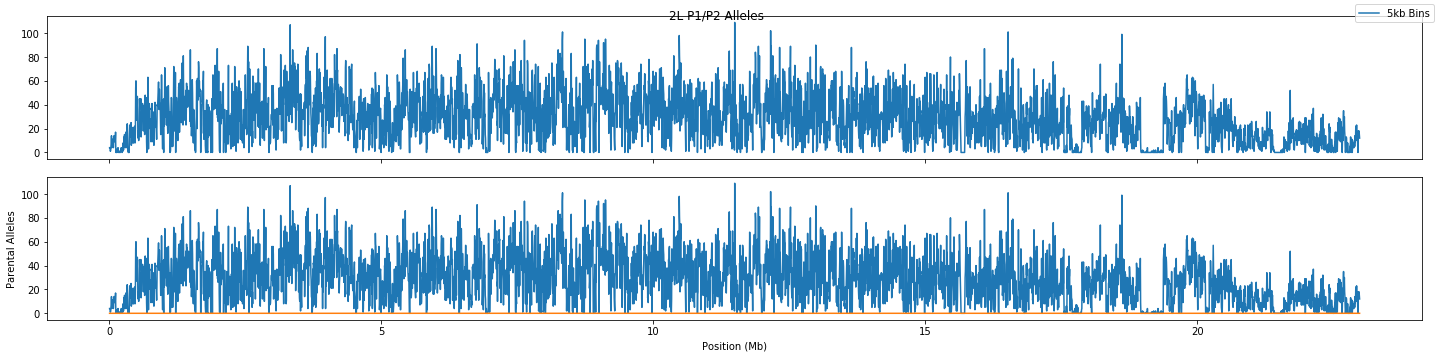

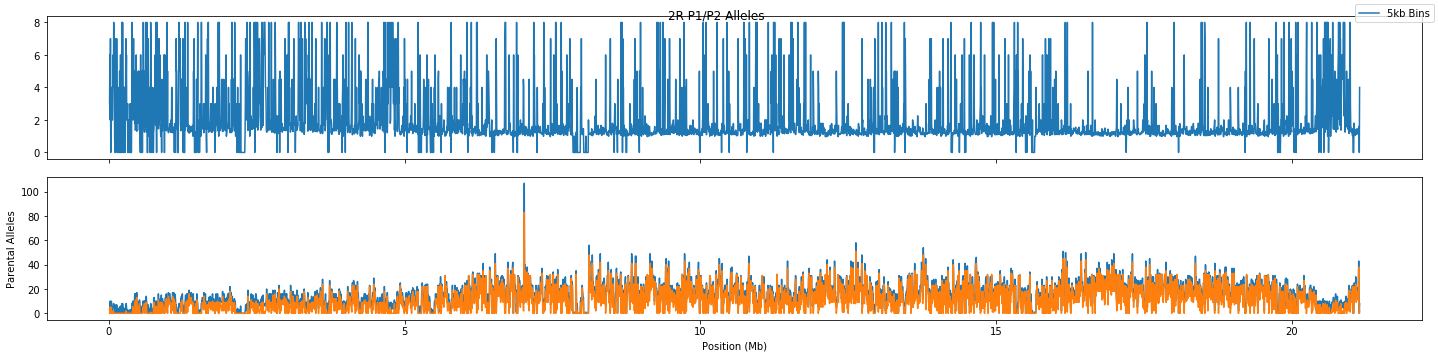

In [54]:
bin_SNP(called_snps[0], chromosome='2L')
bin_SNP(called_snps[1], chromosome='2R')

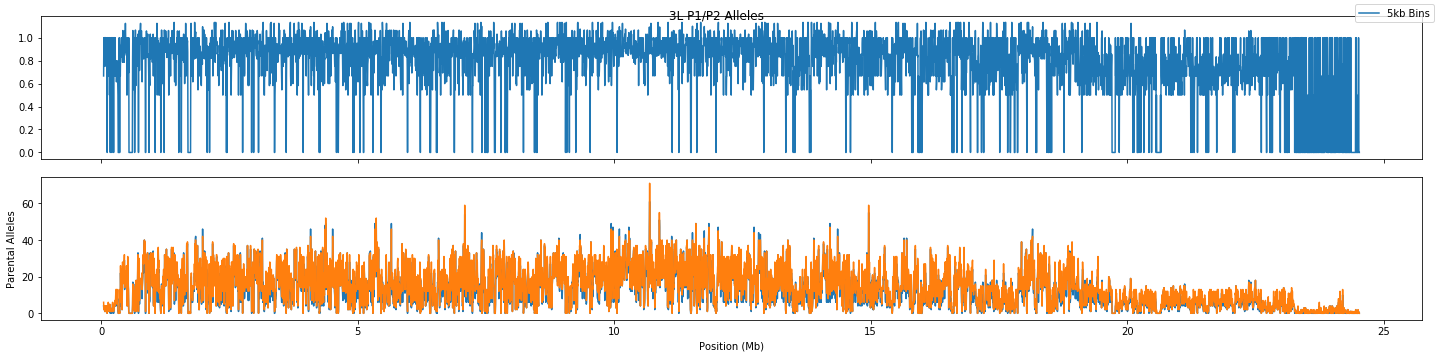

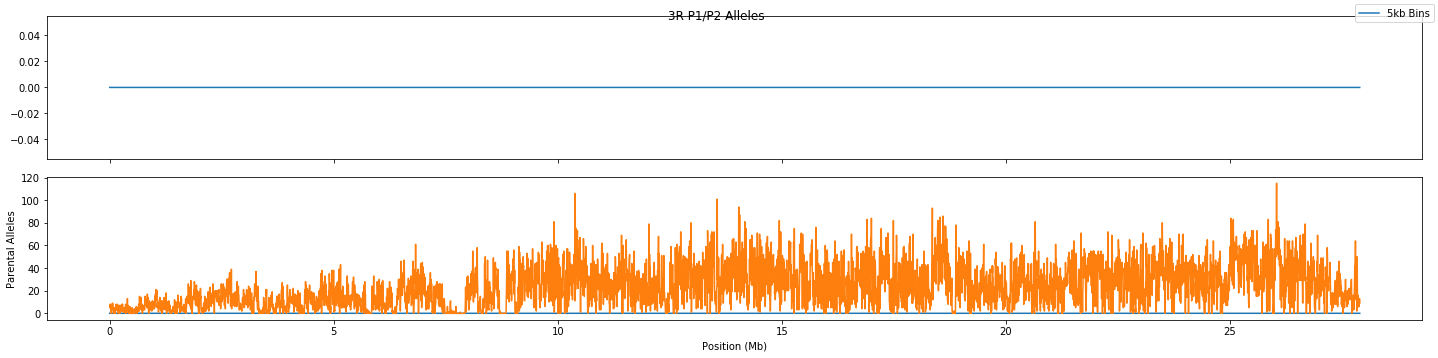

In [55]:
bin_SNP(called_snps[2], chromosome='3L')
bin_SNP(called_snps[3], chromosome='3R')

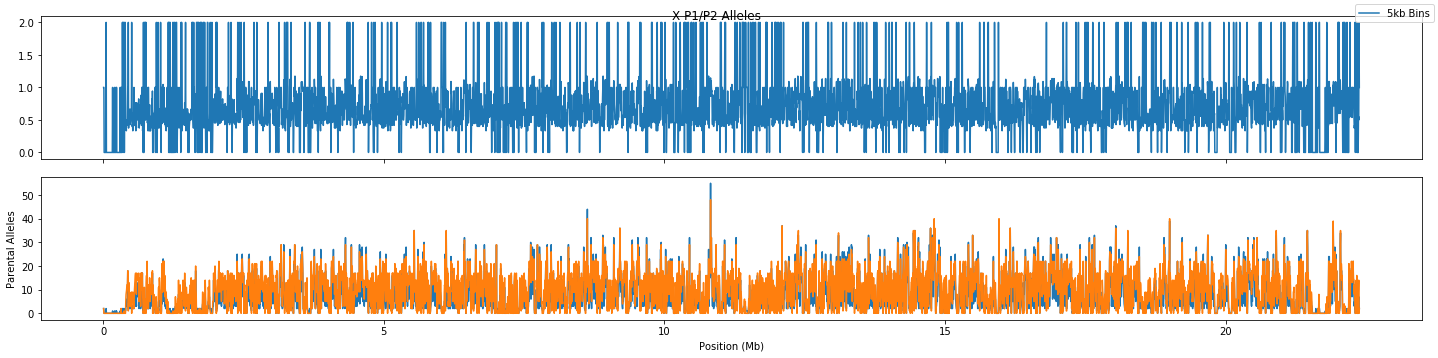

In [33]:
bin_SNP(called_snps[4], chromosome='X')


The above visualization is not much clearer I think that the simple line plots so I'm going to go ahead and just use those.

### Introducing sequencing error to simulations

I introduced a few terms to introduce sequencing error in the simulator by simply taking the Illumina described substitution error, which is .001. Using the simplest visualization possible we get the following plots.

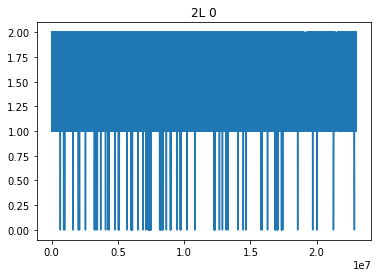

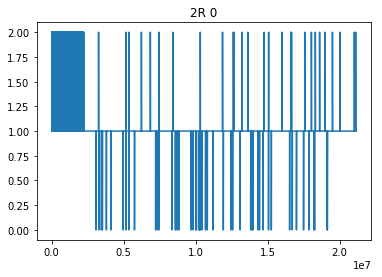

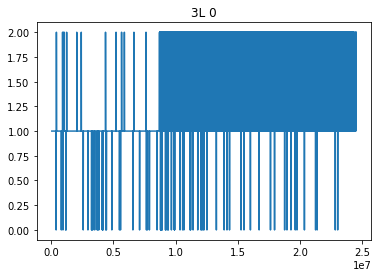

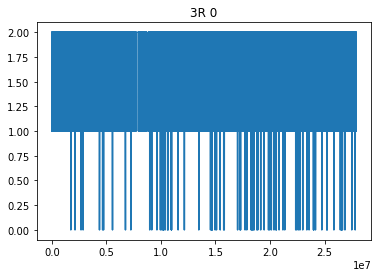

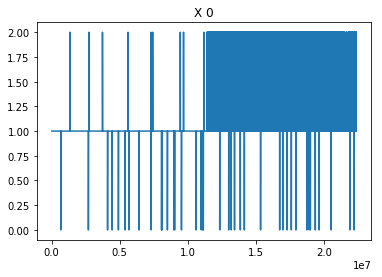

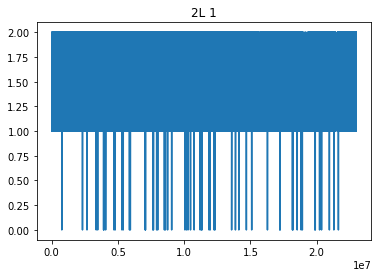

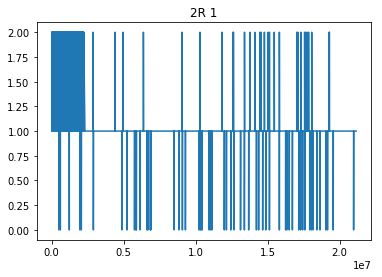

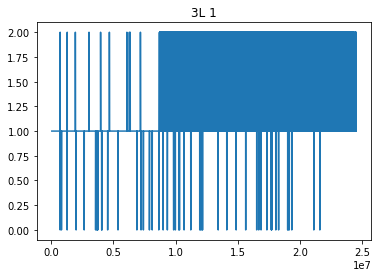

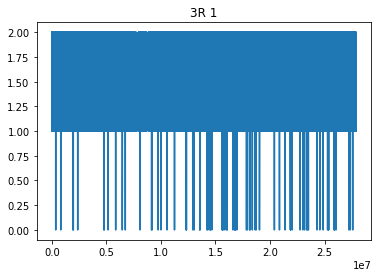

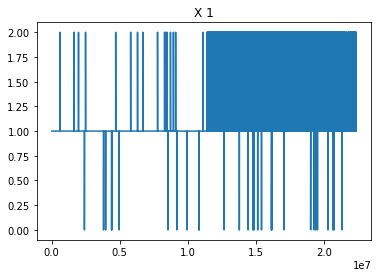

In [15]:
sim_path = os.path.join("/home/iskander/Documents/MEIOTIC_DRIVE/",'new_test.npy')

sim_np = np.load(sim_path)
ID = 0 
for simul in sim_np:
    
   

    called_SNPs = analyzeSIM(npy = simul,path="/home/iskander/Documents/MEIOTIC_DRIVE/", ref_snp="882_129.snp_reference.npy")
    for chr in range(5):
        plt.plot(called_SNPs[chr][:,0], called_SNPs[chr][:,1])
        plt.title('{0} {1}'.format(chromosomes[chr], ID))
        plt.show()
        
    ID += 1
    

    

These plots are pretty dirty looking but they are the easiest and most descriptive. I spent too much time trying to make these things look pretty when I could've been doing something actually useful. Anyway, the introduction of error shows that it seriously messes with our signal. The large blocks that are around the 2 are the oscilations between 1 and 2 that signify heterozygosity. The errors that hit 0's are errors that are not called as P1 or P2 -- those errors shouldn't effect us. But the errors that are important are the ones that call a region as P2 in the P1 homozygote region. But given the visual differences between the two regions in the plots I think it shouldn't be too complicated to detect these regions with my tools.

My next step now that I know my simulator is working correctly is to simply generate like 500 or so individuals with some proportion of the same individual (need a term for this). I think a reasonable number may be like 5%, repeat individuals? In reality this will be a function of how many individuals we put into the nuclear homogenate.  